In [15]:
import os
import pandas as pd
import librosa
import librosa.display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import tqdm.notebook as tqdm
from torchsummary import summary
import torch.optim as optim
from scipy.signal import butter, lfilter, sosfilt, sosfreqz
os.listdir('data/freesound-audio-tagging')

['audio_test',
 'audio_train',
 'sample_submission.csv',
 'test_post_competition.csv',
 'train.csv',
 'train_post_competition.csv']

In [2]:
len(os.listdir('data/freesound-audio-tagging/audio_train'))
df = pd.read_csv('data/freesound-audio-tagging/train.csv')
df.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [3]:
sr = 44100
input_length = int(sr/2)
batch_size = 32


def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5


def load_audio_file(file_path, input_length=input_length):
    data = librosa.core.load(file_path, sr=sr)[0] 
    
    if len(data)>input_length:
        max_offset = len(data)-input_length
        offset = np.random.randint(max_offset)
        data = data[offset:input_length+offset]
        
    else:
        T = np.zeros(input_length, dtype=float)
        T[:len(data)] = data
        data = T
        #max_offset = input_length - len(data)
        ##offset = np.random.randint(max_offset)
        #data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        
    data = audio_norm(data)
    return np.array([data])

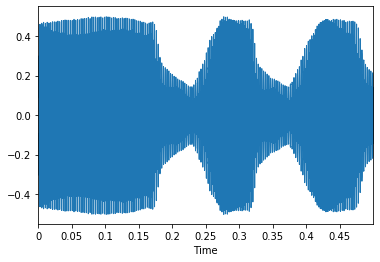

In [5]:
librosa.display.waveplot(load_audio_file('data/freesound-audio-tagging/audio_train/001ca53d.wav')[0],
                         sr=sr, 
                         max_points=50000.0, 
                         x_axis='time', 
                         offset=0.0)

# Data Loading

In [6]:
labels = sorted(set(df.label))
label_to_indice = {l:i for i,l in enumerate(labels)}
indice_to_label = {i:l for i,l in enumerate(labels)}

In [8]:
def bandpass_filter(signal, low, high, order = 5):
    sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
    y = sosfilt(sos, signal)
    return y
    
def make_signal(raw_signal, nyq):
    return_signal = np.zeros((8, len(raw_signal)))
    return_signal[0] = raw_signal

    cut_offs = [i/nyq for i in [1, 256, 512, 1024, 2048, 4096, 8192, 11024]]
    for i in range(1, len(cut_offs), 1):
        return_signal[i] = bandpass_filter(raw_signal, cut_offs[i-1], cut_offs[i])
    return return_signal
        
    
def shuffletwo(x, y):
    rng_state = np.random.get_state()
    np.random.shuffle(x)
    np.random.set_state(rng_state)
    np.random.shuffle(y)

In [12]:
class FreeSoundDataset(torch.utils.data.Dataset):
    def __init__(self, df_path, data_path, train=True, split=0.8):
        
        self.df = pd.read_csv(df_path)
        
        self.df = self.df[:int(len(self.df)*split)] if train else self.df[int(len(self.df)*split):]
        
        self.data_path = data_path
        self.sr = 44100
        self.input_length = int(sr/2)
        self.batch_size = 32
        
        self.labels = sorted(set(self.df.label))
        self.label_to_indice = {l:i for i,l in enumerate(self.labels)}
        self.indice_to_label = {i:l for i,l in enumerate(self.labels)}
    
    def __len__(self):
        return len(self.df)-2
    
    def __getitem__(self, idx):
        file_path = self.data_path + list(df[idx: idx+1].fname)[0]
        label_indice = label_to_indice[list(df[idx: idx+1].label)[0]]
        return make_signal(load_audio_file(file_path)[0], 22050), label_indice
        

In [16]:
FreeSoundData = FreeSoundDataset('data/freesound-audio-tagging/train.csv',
                                 'data/freesound-audio-tagging/audio_train/')
FreeSoundDataTest = FreeSoundDataset('data/freesound-audio-tagging/train.csv',
                                     'data/freesound-audio-tagging/audio_train/',
                                     train=False)
FreeSoundDataLoader = DataLoader(FreeSoundData, batch_size=32, shuffle=True)
FreeSoundDataTestLoader = DataLoader(FreeSoundDataTest, batch_size=32, shuffle=32)

# Model

In [20]:
class FreeSound_Sense(torch.nn.Module):
    
    def __init__(self):
        super(FreeSound_Sense, self).__init__()
        self.conv1d_1_16_9 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=9, padding=True)
        self.conv1d_16_16_9 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=9, padding=True)
        self.conv1d_16_32_3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=True)
        self.conv1d_32_32_3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=True)
        self.conv1d_32_256_3 = nn.Conv1d(in_channels=32, out_channels=256, kernel_size=3, padding=True)
        self.conv1d_256_256_3 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding=True)
        
        self.maxpool_16 = nn.MaxPool1d(16)
        self.maxpool_4 = nn.MaxPool1d(4)
        
        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.1)
        
        self.fc_256_64 = nn.Linear(in_features=256, out_features=64)
        self.fc_64_1024 = nn.Linear(in_features=64, out_features=1024)
        self.fc_1024_42 = nn.Linear(in_features=1024, out_features=42)
        
        
    def forward(self, x):
        
        # First Block
        x = self.conv1d_1_16_9(x)
        x = self.relu(x)
        x = self.conv1d_16_16_9(x)
        x = self.relu(x)
        x = self.maxpool_16(x)
        x = self.dropout(x)
        
        # Second Block
        x = self.conv1d_16_32_3(x)
        x = self.relu(x)
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = self.dropout(x)
        
        # Third Block
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = self.dropout(x)
        
        # Fourth Block
        x = self.conv1d_32_256_3(x)
        x = self.relu(x)
        x = self.conv1d_256_256_3(x)
        x = self.relu(x)
        x = torch.mean(x, 2)
 
        # Final Layers
        x = torch.flatten(x, start_dim=1)
        x = self.fc_256_64(x)
        x = self.relu(x)
        x = self.fc_64_1024(x)
        x = self.relu(x)
        x = self.fc_1024_42(x)
        x = self.softmax(x)
        
        return x

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Model = FreeSound_Sense()
Model.float()
Model.to(device)
summary(Model, (8, 22050))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 16, 22044]           1,168
              ReLU-2            [-1, 16, 22044]               0
            Conv1d-3            [-1, 16, 22038]           2,320
              ReLU-4            [-1, 16, 22038]               0
         MaxPool1d-5             [-1, 16, 1377]               0
           Dropout-6             [-1, 16, 1377]               0
            Conv1d-7             [-1, 32, 1377]           1,568
              ReLU-8             [-1, 32, 1377]               0
            Conv1d-9             [-1, 32, 1377]           3,104
             ReLU-10             [-1, 32, 1377]               0
        MaxPool1d-11              [-1, 32, 344]               0
          Dropout-12              [-1, 32, 344]               0
           Conv1d-13              [-1, 32, 344]           3,104
             ReLU-14              [-1, 

In [23]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
Model = FreeSound_Sense()
Model.float()
Model.to(device)

FreeSound_Sense(
  (conv1d_1_16_9): Conv1d(8, 16, kernel_size=(9,), stride=(1,), padding=(True,))
  (conv1d_16_16_9): Conv1d(16, 16, kernel_size=(9,), stride=(1,), padding=(True,))
  (conv1d_16_32_3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(True,))
  (conv1d_32_32_3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(True,))
  (conv1d_32_256_3): Conv1d(32, 256, kernel_size=(3,), stride=(1,), padding=(True,))
  (conv1d_256_256_3): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(True,))
  (maxpool_16): MaxPool1d(kernel_size=16, stride=16, padding=0, dilation=1, ceil_mode=False)
  (maxpool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (sigm): Sigmoid()
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc_256_64): Linear(in_features=256, out_features=64, bias=True)
  (fc_64_1024): Linear(in_features=64, out_features=1024, bias=True)
  (fc_1024_42): Linear(in_features=1024, out_features=

In [24]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(Model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(Model.parameters(), lr=0.0002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [25]:
epoch_progress_bar = tqdm.tqdm(range(0, 300))
for epoch in epoch_progress_bar:
    avg_epoch_loss = 0
    data_progress_bar = tqdm.tqdm(FreeSoundDataLoader)
    positives=0
    for data, targets in data_progress_bar:
        data = data.float().to(device)
        targets = targets.long().to(device)
        

        optimizer.zero_grad()
        outputs = Model(data)
        

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        avg_epoch_loss+=loss_val
        data_progress_bar.set_description(desc="Loss: "+str(loss_val))
        
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        targets = targets.cpu().numpy()
        positives += np.sum(targets==outputs)
    
    print('Epoch Loss: ', str(avg_epoch_loss/len(FreeSoundDataLoader)))
    print('Train Acc ', str(positives*100/(len(FreeSoundDataLoader)*32)))
    
    # Validation
    data_test_progress_bar = tqdm.tqdm(FreeSoundDataTestLoader)
    positives=0
    for data, targets in data_test_progress_bar:
        data = data.float().to(device)
        targets = targets.numpy()
        outputs = Model(data)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        positives += np.sum(targets==outputs)
        
    print('Valid Acc ', str(positives*100/(len(FreeSoundDataTestLoader)*32)))


Epoch Loss:  3.733191504257138
Train Acc  2.848101265822785



Valid Acc  3.3854166666666665



Epoch Loss:  3.7306915466292496
Train Acc  2.7953586497890295



Valid Acc  2.9166666666666665



Epoch Loss:  3.715510893471633
Train Acc  4.404008438818566



Valid Acc  5.729166666666667



Epoch Loss:  3.713287909825643
Train Acc  6.02584388185654



Valid Acc  6.354166666666667



Epoch Loss:  3.70093155712015
Train Acc  7.502637130801688



Valid Acc  8.28125



Epoch Loss:  3.697300950183144
Train Acc  7.6608649789029535



Valid Acc  7.604166666666667



Epoch Loss:  3.6949290997871365
Train Acc  8.109177215189874



Valid Acc  9.0625



Epoch Loss:  3.6952036905892287
Train Acc  7.871835443037975



Valid Acc  8.90625



Epoch Loss:  3.691720095364856
Train Acc  8.280590717299578



Valid Acc  9.270833333333334



Epoch Loss:  3.69292389793235
Train Acc  8.26740506329114



Valid Acc  9.114583333333334



Epoch Loss:  3.6894188681735267
Train Acc  8.636603375527427



Valid Acc  9.166666666666666



Epoch Loss:  3.6840457403207125
Train Acc  9.177215189873417



Valid Acc  9.479166666666666



Epoch Loss:  3.6830831660500056
Train Acc  9.361814345991561



Valid Acc  9.114583333333334



Epoch Loss:  3.685188674725561
Train Acc  9.04535864978903



Valid Acc  9.166666666666666



Epoch Loss:  3.683712968343421
Train Acc  9.295886075949367



Valid Acc  8.75



Epoch Loss:  3.6836195283801243
Train Acc  9.361814345991561



Valid Acc  8.802083333333334



Epoch Loss:  3.6863206549535823
Train Acc  8.939873417721518



Valid Acc  8.4375



Epoch Loss:  3.6813991894701865
Train Acc  9.49367088607595



Valid Acc  9.21875



Epoch Loss:  3.6800854920334958
Train Acc  9.731012658227849



Valid Acc  10.46875



Epoch Loss:  3.682680430794567
Train Acc  9.440928270042194



Valid Acc  10.416666666666666



Epoch Loss:  3.680646411477262
Train Acc  9.546413502109704



Valid Acc  10.260416666666666



Epoch Loss:  3.6744462216453715
Train Acc  10.245253164556962



Valid Acc  10.104166666666666



Epoch Loss:  3.679751289544729
Train Acc  9.796940928270041



Valid Acc  10.572916666666666



Epoch Loss:  3.6809093740921988
Train Acc  9.427742616033756



Valid Acc  7.083333333333333



Epoch Loss:  3.67838627577834
Train Acc  9.796940928270041



Valid Acc  10.15625



Epoch Loss:  3.6739976808491637
Train Acc  10.337552742616033



Valid Acc  10.416666666666666



Epoch Loss:  3.674107904675641
Train Acc  10.205696202531646



Valid Acc  9.635416666666666



Epoch Loss:  3.674208413699508
Train Acc  10.297995780590718



Valid Acc  9.375



Epoch Loss:  3.68157482549611
Train Acc  9.625527426160337



Valid Acc  10.208333333333334



Epoch Loss:  3.6834134190394408
Train Acc  9.282700421940929



Valid Acc  10.364583333333334



Epoch Loss:  3.682912865771523
Train Acc  9.375



Valid Acc  10.052083333333334


KeyboardInterrupt: 

In [26]:
torch.save(Model.state_dict(), "FreeSound_1D_conv_8CH_global_pool_30_epoch.stDict")

In [27]:
i=0
for data in FreeSoundDataLoader:
    if i==4:
        O = Model(data[0].float().to(device))
        A = data[1]
        #print(data[1])
        break
    i+=1
O = O.detach().cpu().numpy()
K = np.argmax(O, axis=1)==A.numpy()
print(np.sum(K)/len(K), np.sum(K))
list(zip(A, K))

0.125 4


[(tensor(29), False),
 (tensor(31), False),
 (tensor(8), False),
 (tensor(23), True),
 (tensor(6), False),
 (tensor(30), False),
 (tensor(23), False),
 (tensor(32), False),
 (tensor(34), False),
 (tensor(34), False),
 (tensor(32), False),
 (tensor(36), False),
 (tensor(26), False),
 (tensor(35), False),
 (tensor(23), True),
 (tensor(20), False),
 (tensor(17), False),
 (tensor(38), False),
 (tensor(20), False),
 (tensor(9), False),
 (tensor(18), False),
 (tensor(30), False),
 (tensor(6), False),
 (tensor(5), False),
 (tensor(1), True),
 (tensor(0), False),
 (tensor(33), False),
 (tensor(6), False),
 (tensor(20), False),
 (tensor(39), True),
 (tensor(37), False),
 (tensor(31), False)]